# Descriptive Statistics

In [ ]:
# Mathematical and Data Managment
import numpy as np
import pandas as pd
import scipy.sparse as sp
from datetime import datetime

# Graph Managment
import graph_tool.all as gt
import networkx as nx

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Miscellaneous
import pickle
from glob import glob
from tqdm import tqdm
import random

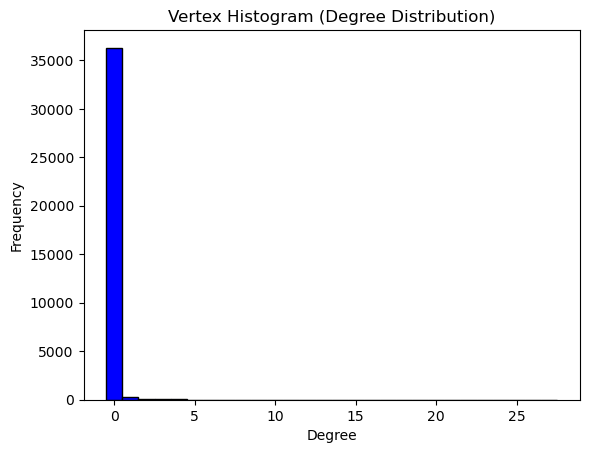

In [10]:
g = gt.load_graph('/mnt/disk2/Data/3_Day_Graphs/2021-05-01.graphml')
deg = gt.vertex_hist(g,'total',bins=[0,200])
plt.figure()
plt.bar(range(len(deg[0])), deg[0], width=1.0, color='b', edgecolor='black')
plt.title('Vertex Histogram (Degree Distribution)')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.show()

In [12]:
files = glob('/mnt/disk2/Data/3_Day_Graphs/*.graphml')

ls = []
for file in files:
    for stat in ['in', 'out']:
        # Get date
        date = file.split('/')[-1].split('.')[0]
        date = datetime.strptime(date, '%Y-%m-%d')
        
        # Get Average
        g = gt.load_graph(file)
        tupla = gt.vertex_average(g, stat)
        
        # Store
        row = [tupla[0], tupla[1], date, stat]
        ls.append(row)

# Get Visualization
viz = pd.DataFrame(ls, columns=['Average','SE','Date', 'Type'])

# Get Confidence Interval
viz['Lower'] = viz['Average'] - 1.96*viz['SE']
viz['Upper'] = viz['Average'] + 1.96*viz['SE']
viz

,Average,SE,Date,Type,Lower,Upper
0,8.298425,0.428918,2021-06-12,in,7.457745,9.139106
1,8.298425,0.096258,2021-06-12,out,8.109760,8.487091
2,17.221810,0.815613,2021-05-08,in,15.623208,18.820413
3,17.221810,0.159613,2021-05-08,out,16.908969,17.534652
4,11.207445,0.557202,2021-05-19,in,10.115330,12.299560
...,...,...,...,...,...,...
117,7.971269,0.097925,2021-06-08,out,7.779336,8.163203
118,13.337896,0.657941,2021-05-31,in,12.048332,14.627461
119,13.337896,0.135968,2021-05-31,out,13.071399,13.604394
120,11.340358,0.583169,2021-05-17,in,10.197348,12.483369


/tmp/ipykernel_462254/3744972097.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  in_deg.sort_index(inplace=True)
/tmp/ipykernel_462254/3744972097.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  out_deg.sort_index(inplace=True)


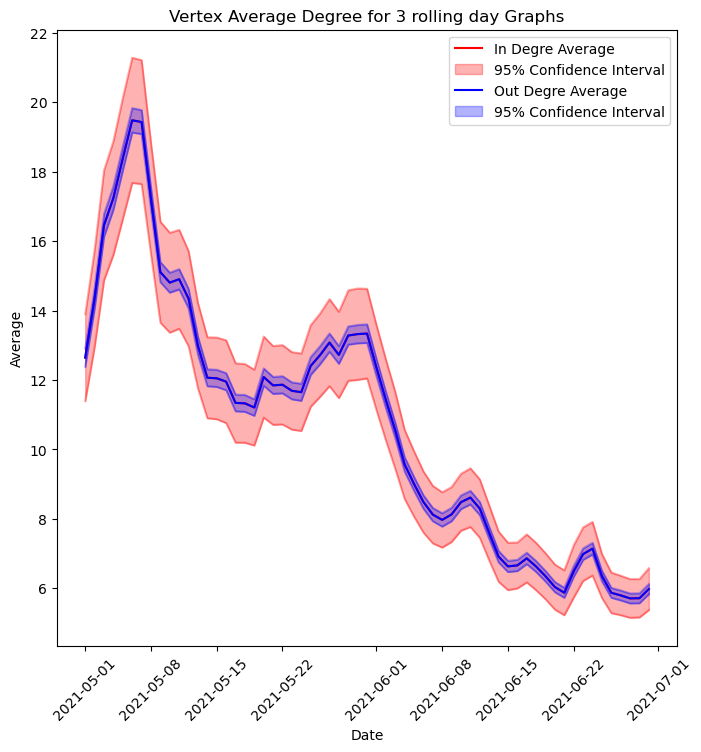

In [13]:
# Separate Types
in_deg = viz[viz['Type'] == 'in']
out_deg = viz[viz['Type'] == 'out']

# Specify Indexes
in_deg.set_index('Date', inplace=True)
out_deg.set_index('Date', inplace=True)

in_deg.sort_index(inplace=True)
out_deg.sort_index(inplace=True)

# GRAAAAAPH
fig, ax = plt.subplots(figsize=(8, 8))

# In Graph
sns.lineplot(data=in_deg, x=in_deg.index, y='Average', color='red', ax=ax, label='In Degre Average')
sns.lineplot(data=in_deg, x=in_deg.index, y='Lower', color='red', ax=ax, alpha=0.3, label='_nolegend_')
sns.lineplot(data=in_deg, x=in_deg.index, y='Upper', color='red', ax=ax, alpha=0.3, label='_nolegend_')

plt.fill_between(in_deg.index, in_deg['Lower'], in_deg['Upper'], color='red', alpha=0.3, label='95% Confidence Interval')

# Out Graph
sns.lineplot(data=out_deg, x=out_deg.index, y='Average', color='blue', ax=ax, label='Out Degre Average')
sns.lineplot(data=out_deg, x=out_deg.index, y='Lower', color='blue', ax=ax, alpha=0.3, label='_nolegend_')
sns.lineplot(data=out_deg, x=out_deg.index, y='Upper', color='blue', ax=ax, alpha=0.3, label='_nolegend_')

plt.fill_between(out_deg.index, out_deg['Lower'], out_deg['Upper'], color='blue', alpha=0.3, label='95% Confidence Interval')

# Labels
plt.title('Vertex Average Degree for 3 rolling day Graphs')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend()
plt.show()